<a href="https://colab.research.google.com/github/AlexanderPiavis/GSB544/blob/main/Practice_Activity_kNN_and_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

!pip install palmerpenguins
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()

X = penguins.drop("bill_depth_mm", axis = 1)
y = penguins["bill_depth_mm"]

In [3]:
# Code Here
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # handle_unknown for new dummy vars
    make_column_selector(dtype_include=object)), # Find all columns of a certain type
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number)) # includes any number variable
  ],
  remainder = "drop"
)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [7]:
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)
scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
scores.mean()

np.float64(0.3948378362912914)

In [6]:
kNN_pipeline5 = Pipeline(
    [("preprocessing", ct),
     ("kNN_regression", KNeighborsRegressor(n_neighbors=5))]
)
kNN_pipeline10 = Pipeline(
    [("preprocessing", ct),
     ("kNN_regression", KNeighborsRegressor(n_neighbors=10))]
)

scores5 = cross_val_score(kNN_pipeline5, X, y, cv=5, scoring='r2')
scores10 = cross_val_score(kNN_pipeline10, X, y, cv=5, scoring='r2')
print(scores5.mean(), scores10.mean())

0.1468438878985719 0.14885570659978092


In [22]:
depths = [1, 2, 4, 6,None]
results = {}

for d in depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    pipe = Pipeline([
        ("preprocessing", ct),
        ("decision_tree", tree)
    ])
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    results[d] = scores.mean()

import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=["max_depth", "Average R²"])
print(results_df)


   max_depth  Average R²
0        1.0    0.089037
1        2.0    0.484028
2        4.0    0.310197
3        6.0    0.055240
4        NaN   -0.106198


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

models = {
    "Linear Regression": lr_pipeline,
    "kNN (k=5)": kNN_pipeline5,
    "kNN (k=10)": kNN_pipeline10,
    "Decision Tree (depth=4)": Pipeline([
        ("preprocessing", ct),
        ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
    ])
}

train_errors, test_errors = {}, {}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    results.append({"Model": name, "Set": "Training", "MSE": mean_squared_error(y_train, y_pred_train)})
    results.append({"Model": name, "Set": "Test", "MSE": mean_squared_error(y_test, y_pred_test)})


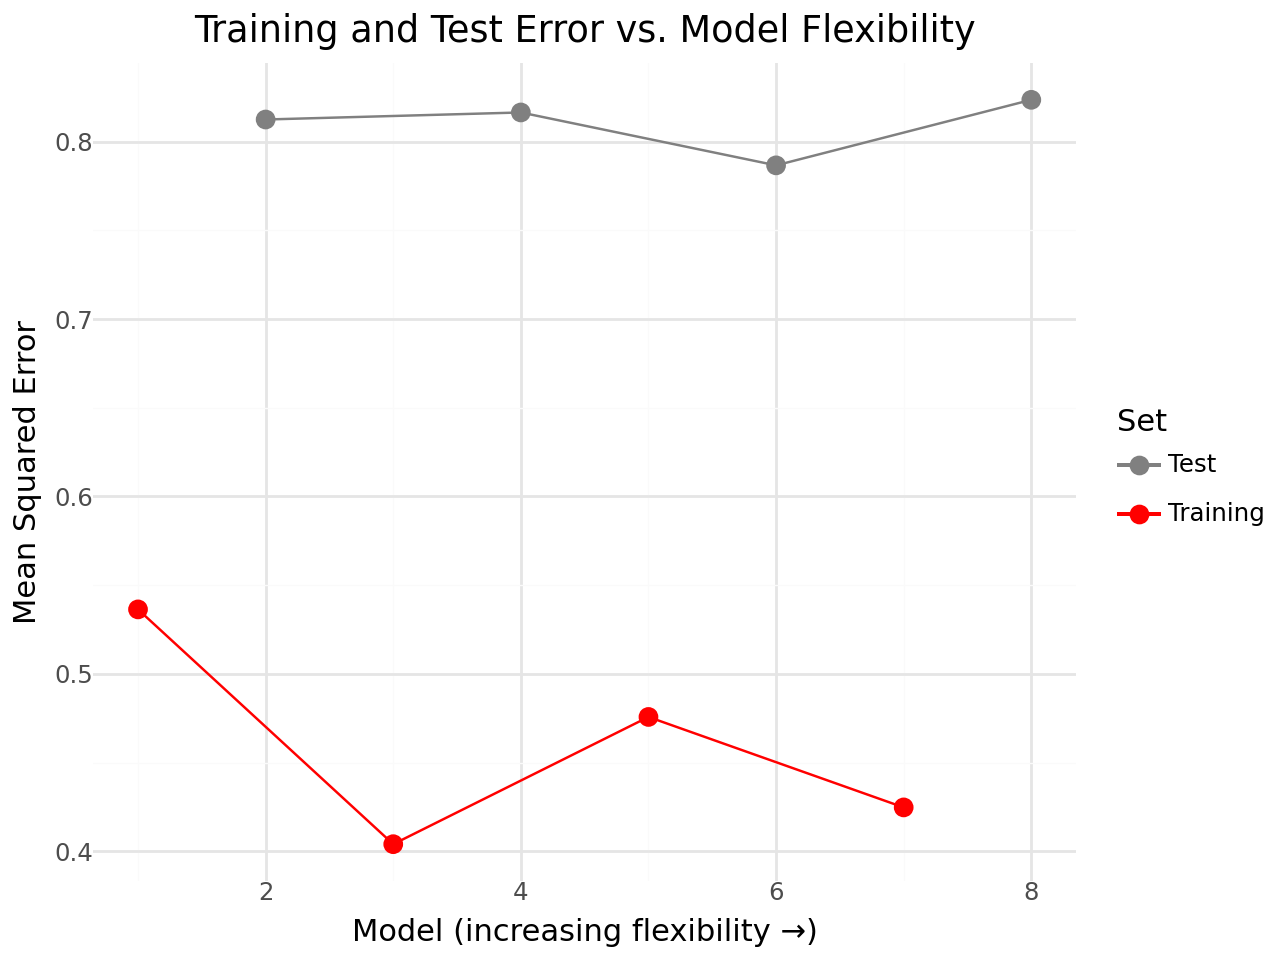

In [15]:
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, scale_color_manual
results_df = pd.DataFrame(results)
results_df["Flexibility"] = range(1, len(models) + 5)  # for plotting order

p = (
    ggplot(results_df, aes(x="Flexibility", y="MSE", color="Set")) +
    geom_line(aes(group="Set")) +
    geom_point(size=3) +
    scale_color_manual(values=["gray", "red"]) +
    labs(
        x="Model (increasing flexibility →)",
        y="Mean Squared Error",
        title="Training and Test Error vs. Model Flexibility"
    ) +
    theme_minimal()
)

p